In [ ]:
!pip install livelossplot
!pip install tensorflow==2.1

     |████████████████████████████████| 421.8MB 22kB/s 
     |████████████████████████████████| 450kB 53.5MB/s 
     |████████████████████████████████| 3.9MB 48.1MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=e6ee2bb6ea68d79b27d47ee3e6d5beda38368b8e69f2ae016b6a25d137b84e3a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd '/content/gdrive/My Drive/Colab Notebooks'

/content/gdrive/My Drive/Colab Notebooks


In [ ]:
cp 'ImageManipulationDataset.zip' '/content'

In [ ]:
cp 'classifier_weights.h5' '/content'

In [ ]:
cd '/content'

/content


In [ ]:
!unzip ImageManipulationDataset.zip

Archive:  ImageManipulationDataset.zip
   creating: Original/
  inflating: Original/Au_ani_0063.jpg  
  inflating: Original/Au_nat_0014.jpg  
  inflating: Original/Au_pla_0009.jpg  
  inflating: Original/Au_cha_0098.jpg  
  inflating: Original/Au_nat_0054.jpg  
  inflating: Original/Au_arc_0025.jpg  
  inflating: Original/Au_sec_0082.jpg  
  inflating: Original/Au_arc_0048.jpg  
  inflating: Original/Au_pla_0036.jpg  
  inflating: Original/Au_arc_0060.jpg  
  inflating: Original/Au_nat_0099.jpg  
  inflating: Original/Au_pla_0099.jpg  
  inflating: Original/Au_cha_0048.JPG  
  inflating: Original/Au_nat_0035.jpg  
  inflating: Original/Au_pla_0077.jpg  
  inflating: Original/Au_cha_0007.jpg  
  inflating: Original/Au_nat_0053.jpg  
  inflating: Original/Au_pla_0079.jpg  
  inflating: Original/Au_art_0010.jpg  
  inflating: Original/Au_arc_0061.jpg  
  inflating: Original/Au_ani_0070.jpg  
  inflating: Original/Au_pla_0066.jpg  
  inflating: Original/Au_art_0048.jpg  
  inflating: Origi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
import os
from PIL import Image, ImageChops, ImageEnhance

ELA Algorithm

In [ ]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = 'tempresaved.jpg'
    ELA_filename = 'tempela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality = quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

Real Image Sample

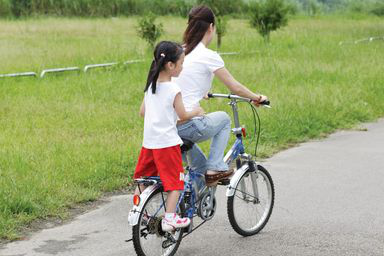

In [ ]:
Image.open('Original/Au_cha_0077.jpg')

ELA of Real Image

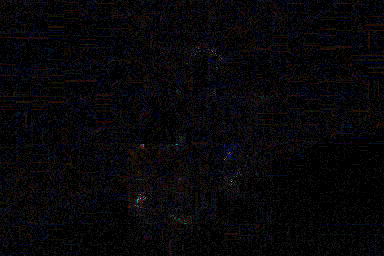

In [ ]:
convert_to_ela_image('Original/Au_cha_0077.jpg', 90)

Fake Image Sample

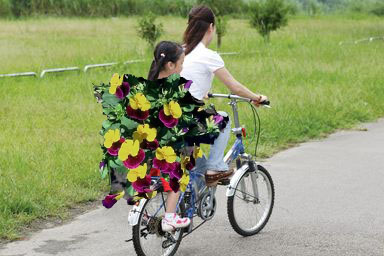

In [ ]:
Image.open('Spliced/Sp_D_CRN_A_cha0077_pla0022_0382.jpg')

ELA of Fake Image

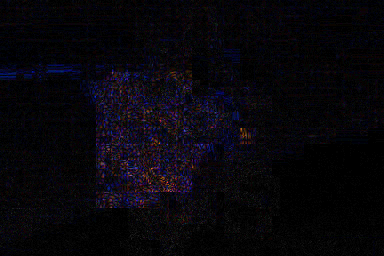

In [ ]:
convert_to_ela_image('Spliced/Sp_D_CRN_A_cha0077_pla0022_0382.jpg', 90)

Pre-processing the data to feed it to the network

In [ ]:
X = []
Y = []

In [ ]:
for i in os.listdir('Original'):
  X.append(np.array(convert_to_ela_image('Original/'+i, 90).resize((256, 256)))/255.0)
  Y.append(0)

for i in os.listdir('Spliced'):
  X.append(np.array(convert_to_ela_image('Spliced/'+i, 90).resize((256, 256)))/255.0)
  Y.append(1)

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
#X = X.reshape(-1, 256, 256, 3)         #-1 means that it will ignore that axis and reshape the rest (if given)
#Y = Y.reshape(-1)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

In [ ]:
print(len(X_train))
print(len(X_val))

700
176


In [ ]:
X.shape

(876, 256, 256, 3)

###Classifier

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu', input_shape = (256,256,3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'valid', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

model.summary()

####Training

In [ ]:
model.compile(optimizer = Adam(lr=0.0001) , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
#model.load_weights('classifier_weights.h5')

In [ ]:
checkpoint = ModelCheckpoint('classifier_weights.h5', monitor='val_accuracy', verbose=1, 
                             save_weights_only=True, save_best_only=True, mode='auto', save_freq='epoch')

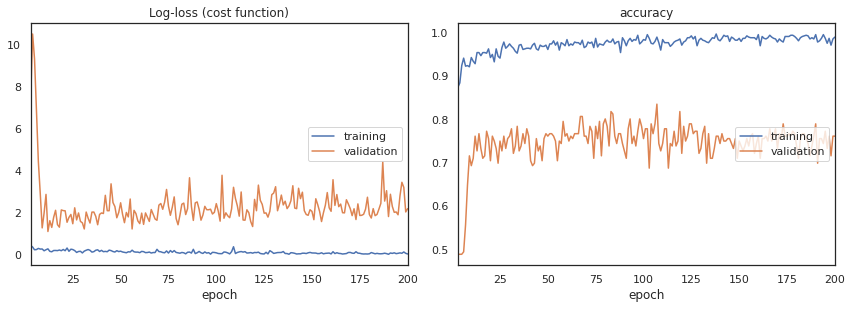

Log-loss (cost function):
training   (min:    0.009, max:    0.958, cur:    0.024)
validation (min:    1.068, max:   10.504, cur:    2.185)

accuracy:
training   (min:    0.707, max:    0.997, cur:    0.990)
validation (min:    0.489, max:    0.835, cur:    0.761)

Epoch 00200: val_accuracy did not improve from 0.83523
700/700 [==============================] - 3s 5ms/sample - loss: 0.0242 - accuracy: 0.9900 - val_loss: 2.1846 - val_accuracy: 0.7614


In [ ]:
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size = 8, epochs = 200, verbose = 1, callbacks=[PlotLossesCallback() ,checkpoint])        #X_train, Y_train, validation_data = (X_val, Y_val)

In [ ]:
np.max(history.history['val_accuracy'])

0.83522725

In [ ]:
np.where(history.history['val_accuracy']==np.max(history.history['val_accuracy']))

(array([106]),)

In [ ]:
history.history['accuracy'][106]

0.99

In [ ]:
cp 'classifier_weights.h5' '/content/gdrive/My Drive/Colab Notebooks/classifier_weights.h5'

Testing

In [ ]:
#test=np.array(convert_to_ela_image('Spliced/Sp_D_CNN_A_ani0049_ani0084_0266.jpg', 90).resize((256, 256))) / 255.0

In [ ]:
test=np.array(convert_to_ela_image('Original/Au_arc_0032.jpg', 90).resize((256, 256))).flatten() / 255.0

In [ ]:
test=test.reshape(-1,256,256,3)

In [ ]:
result=model.predict(test)
print('Chances of being real : ',round(result[0][0],3))
print('Chances of being fake : ',round(result[0][1],3))

Chances of being real :  1.0
Chances of being fake :  0.0


Confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

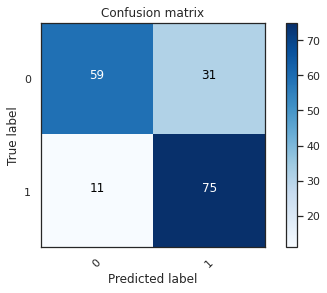

In [ ]:
# Predict the values from the validation dataset
Y_pred = [0 if i[0]>i[1] else 1 for i in model.predict(X_val)]
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, Y_pred) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))